In [1]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError, MeanAbsoluteError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    BlockRNNModel,
    TFTModel
)
from darts.explainability.tft_explainer import TFTExplainer
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)
import csv

import plotly.express as px

### Import data and datetime index

In [2]:
gdpnow = pd.read_csv('train_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

In [3]:
gdpnow

,value_CCLACBW027SBOG,value_WTISPLC,value_EXPINF1YR,value_STLPPM,value_M2REAL,value_UNRATE,value_PPIACO,value_PCUOMFGOMFG,value_PCUATRANSATRANS,value_PCUATRADEATRADE,...,PCE Goods,PCE Services,Previous change in private inventories ($Bil 2009),Publication Date of Advance Estimate,Quarter being forecasted,Residential,S&L,Services exports,Services imports,Structures
Dates,,,,,,,,,,,,,,,,,,,,,
2014-05-01,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,197.200,125.500,124.600,...,5.8,3.9,70.0,30/07/2014,30/06/2014,4.6,1.4,2.5,4.0,1.8
2014-05-02,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,197.200,125.500,124.600,...,5.8,3.9,58.0,30/07/2014,30/06/2014,4.6,1.3,2.5,4.0,1.8
2014-05-03,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,197.200,125.500,124.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-04,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,197.200,125.500,124.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-05,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,197.200,125.500,124.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,1033.2235,74.15,2.418633,0.940888,6710.6,3.7,251.328,244.078,158.986,173.411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-16,1033.2235,74.15,2.418633,0.940888,6710.6,3.7,251.328,244.078,158.986,173.411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17,1035.5004,74.15,2.418633,0.940888,6710.6,3.7,251.328,244.078,158.986,173.411,...,3.6,2.4,77.8,25/01/2024,31/12/2023,0.2,3.6,5.6,5.7,2.0


In [4]:
gdpnow.columns

Index(['value_CCLACBW027SBOG', 'value_WTISPLC', 'value_EXPINF1YR',
       'value_STLPPM', 'value_M2REAL', 'value_UNRATE', 'value_PPIACO',
       'value_PCUOMFGOMFG', 'value_PCUATRANSATRANS', 'value_PCUATRADEATRADE',
       'value_PCUAWHLTRAWHLTR', 'value_CSUSHPINSA', 'value_SPCS20RSA',
       'value_WALCL', 'value_REAINTRATREARAT10Y', 'value_SAHMREALTIME',
       'value_POPTHM', 'value_CES0500000003', 'value_NFCI', 'value_WEI',
       'value_ICSA', 'value_ADPWNUSNERSA', 'value_FEDFUNDS',
       'value_CORESTICKM159SFRBATL', 'value_CPIAUCSL', 'value_PAYEMS',
       'value_MORTGAGE30US', 'USGGBE02 Index', 'USOSFR10 Curncy', 'CL1 Comdty',
       'USOSFR2 Curncy', 'NDX Index ', 'SPX Index ', 'USDJPY Curncy',
       'GSUSFCI Index', 'CESIUSD Index', 'Monthly Nominal GDP Index',
       'Monthly Real GDP Index', 'Advance Estimate From BEA',
       'Business Fixed Investment',
       'Change in inventory investment ($Bil 2009)',
       'Change in net exports ($Bil 2009)',
       'Current chang

## Only the target

In [5]:
'SPX Index 'in gdpnow.columns

True

In [6]:
start_date = '2014-05-01'
end_date = '2024-01-19'

In [7]:
#Target S&P
Target = 'SPX Index '
# SPX Index remains!
Drop = ['Final_GDP_Interp','Quarter being forecasted',
        'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
        'Days until advance estimate', 'Forecast Error', 'Data releases',
        'NDX Index ']

In [8]:
y = gdpnow[['SPX Index ']]
past_cov = gdpnow[['Intellectual Property Products', 'NDX Index ', 'CESIUSD Index']]

In [9]:
px.line(y)

In [10]:
px.line(past_cov)

### Check some null values columns

In [11]:
# px.line(gdpnow['Residential'])

In [12]:
past_cov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3551 entries, 2014-05-01 to 2024-01-19
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Intellectual Property Products  1496 non-null   float64
 1   NDX Index                       3551 non-null   float64
 2   CESIUSD Index                   3551 non-null   float64
dtypes: float64(3)
memory usage: 111.0 KB


In [13]:
# gdpnow = gdpnow.select_dtypes(exclude=['object'])
# gdpnow.info()

### Into darts timeseries 

In [14]:
y_dartseries = TimeSeries.from_dataframe(y, freq='D')
past_cov_dartseries = TimeSeries.from_dataframe(past_cov, freq='D')

### Plot target

<Axes: xlabel='Dates'>

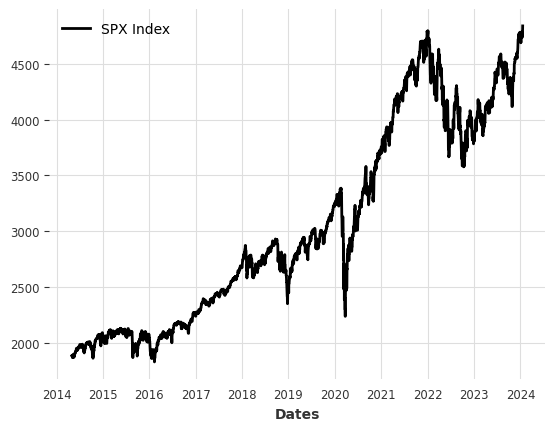

In [15]:
y_dartseries.plot()

### Plot past-covariates

<Axes: xlabel='Dates'>

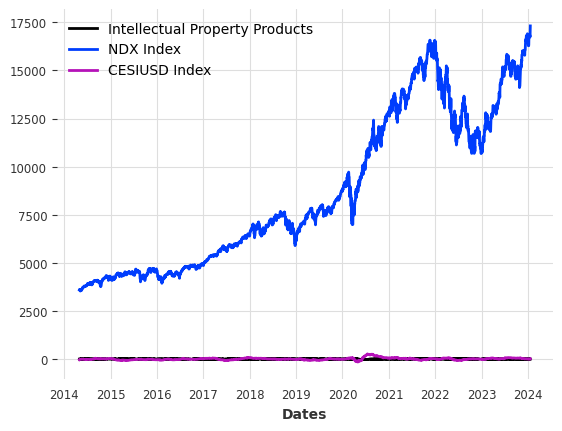

In [16]:
past_cov_dartseries.plot()

### Check if we have missing values in darts timeseries object

In [17]:
past_cov_dartseries.pd_dataframe().isna().sum().sort_values(ascending=False)

component
Intellectual Property Products    2055
NDX Index                            0
CESIUSD Index                        0
dtype: int64

### Remove missing values with interpolation

<Axes: xlabel='Dates'>

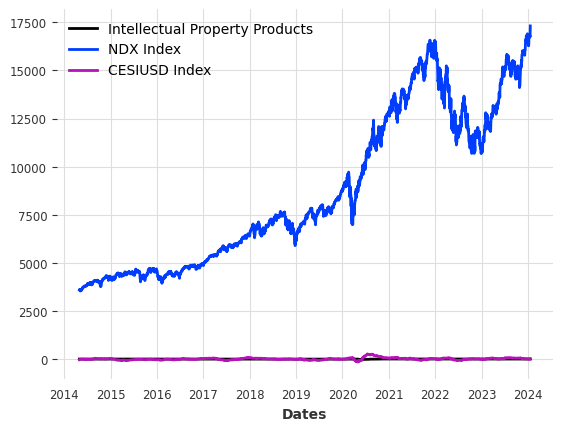

In [18]:
from darts.utils.missing_values import fill_missing_values
y_dartseries = fill_missing_values(y_dartseries)
past_cov_dartseries = fill_missing_values(past_cov_dartseries)
past_cov_dartseries.plot()

In [19]:
past_cov_dartseries.pd_dataframe().isna().sum().sort_values(ascending=False)

component
Intellectual Property Products    0
NDX Index                         0
CESIUSD Index                     0
dtype: int64

### Train Test split

In [20]:
y_train_ds, y_val_ds = (y_dartseries).split_before(0.95)
past_cov_train_ds, past_cov_val_ds = (past_cov_dartseries).split_before(0.95)

In [21]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
past_cov_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)

In [22]:
y_train_scaled_ds = target_transformer.fit_transform(y_train_ds)
y_val_scaled_ds = target_transformer.transform(y_val_ds)
past_cov_train_scaled_ds = past_cov_transformer.fit_transform(past_cov_train_ds)
past_cov_val_scaled_ds = past_cov_transformer.transform(past_cov_val_ds)

<Axes: xlabel='Dates'>

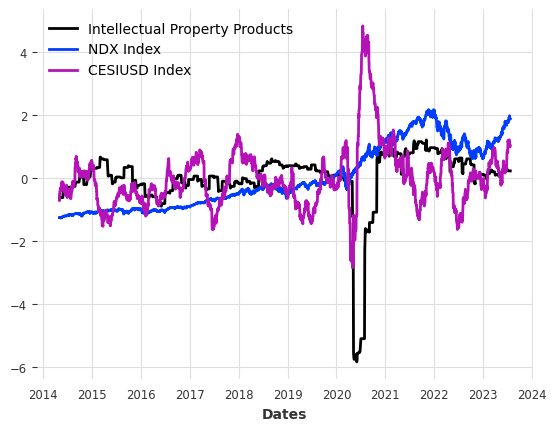

In [23]:
past_cov_train_scaled_ds.plot()

In [24]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=50,
    min_delta=0.005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "cpu"}

# To use GPU
# pl_trainer_kwargs={"callbacks": [my_stopper],
#                    "accelerator": "gpu",
#                    "devices": [0]}

In [25]:
# predict 15 days considering the latest 45 days
input_chunk_length=14
output_chunk_length=1


model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    dropout=0.5,
    torch_metrics=MeanAbsoluteError(),
    n_epochs=100,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
    n_rnn_layers=6,
    hidden_dim=50
)

In [26]:
model_pastcov.fit(
    series=y_train_scaled_ds,                     # the target training data
    past_covariates=past_cov_train_scaled_ds,     # the multi covariate features training data
    val_series=y_val_scaled_ds,                   # the target validation data
    val_past_covariates=past_cov_val_scaled_ds,   # the multi covariate features validation data
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=50, n_rnn_layers=6, hidden_fc_sizes=None, dropout=0.5, input_chunk_length=14, output_chunk_length=1, torch_metrics=MeanAbsoluteError(), n_epochs=100, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x29db60f70>], 'accelerator': 'cpu'}, random_state=0)

In [27]:
temp = model_pastcov.predict(n=1,                        # n of days to predict
                            series=y_val_scaled_ds[:input_chunk_length],  # target input for prediction
                            past_covariates=past_cov_val_scaled_ds[:input_chunk_length])

Predicting: |          | 0/? [00:00<?, ?it/s]

In [28]:
print(target_transformer.inverse_transform(temp).values())
print(target_transformer.inverse_transform(y_val_scaled_ds[Target][15]).values())

[[4641.75907096]]
[[4467.71]]


In [29]:
y_pred = []
y_real = []

for i in range(len(y_val_scaled_ds[:-input_chunk_length-1])):
    prediction_1d = model_pastcov.predict(n=1,
                          series=y_val_scaled_ds[i:input_chunk_length+i],
                          past_covariates=past_cov_val_scaled_ds[i:input_chunk_length+i])
    y_pred.append(target_transformer.inverse_transform(prediction_1d).values()[0][0])
    y_real.append(target_transformer.inverse_transform(y_val_scaled_ds[input_chunk_length+1+i]).values()[0][0])

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [30]:
df_validation = {'s&p':y_real, 'prediction':y_pred}
df_validation = pd.DataFrame(df_validation)
df_validation

,s&p,prediction
0,4467.71,4641.759071
1,4468.83,4636.726955
2,4464.05,4622.813672
3,4464.05,4606.471312
4,4464.05,4591.767366
...,...,...
159,4783.83,4703.862328
160,4765.98,4704.065569
161,4739.21,4704.218598
162,4780.94,4704.307947


In [31]:
px.line(df_validation)

In [32]:
df_validation['predicted delta'] = 0
df_validation['real delta'] = 0

for i in range(len(df_validation)-1):
    df_validation['predicted delta'].iloc[i] = \
        df_validation['prediction'].iloc[i+1] \
        -df_validation['s&p'].iloc[i]

    df_validation['real delta'].iloc[i] = \
        df_validation['s&p'].iloc[i+1] \
        -df_validation['s&p'].iloc[i]

df_validation

,s&p,prediction,predicted delta,real delta
0,4467.71,4641.759071,169.016955,1.12
1,4468.83,4636.726955,153.983672,-4.78
2,4464.05,4622.813672,142.421312,0.00
3,4464.05,4606.471312,127.717366,0.00
4,4464.05,4591.767366,114.417330,25.67
...,...,...,...,...
159,4783.83,4703.862328,-79.764431,-17.85
160,4765.98,4704.065569,-61.761402,-26.77
161,4739.21,4704.218598,-34.902053,41.73
162,4780.94,4704.307947,-76.617806,58.87


In [33]:
def smape_function(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
    - actual: array containing actual values
    - predicted: array containing predicted values

    Returns:
    - SMAPE value
    """
    denominator = (np.abs(actual) + np.abs(predicted)) / 2.0
    diff = np.abs(actual - predicted) / denominator
    # diff[denominator == 0] = 0.0  # Handle division by zero
    smape_value = np.mean(diff) * 100.0

    return smape_value

In [34]:
smape_function(df_validation['s&p'], df_validation.prediction)

2.0145365167241467

In [35]:
df_validation.to_csv('deep.csv', index=False)

# Lets look one week into the future!

In [36]:
y_train_ds, y_val_ds = (y_dartseries).split_before(0.95)
past_cov_train_ds, past_cov_val_ds = (past_cov_dartseries).split_before(0.95)

In [37]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
past_cov_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)

In [38]:
y_train_scaled_ds = target_transformer.fit_transform(y_train_ds)
y_val_scaled_ds = target_transformer.transform(y_val_ds)
past_cov_train_scaled_ds = past_cov_transformer.fit_transform(past_cov_train_ds)
past_cov_val_scaled_ds = past_cov_transformer.transform(past_cov_val_ds)

<Axes: xlabel='Dates'>

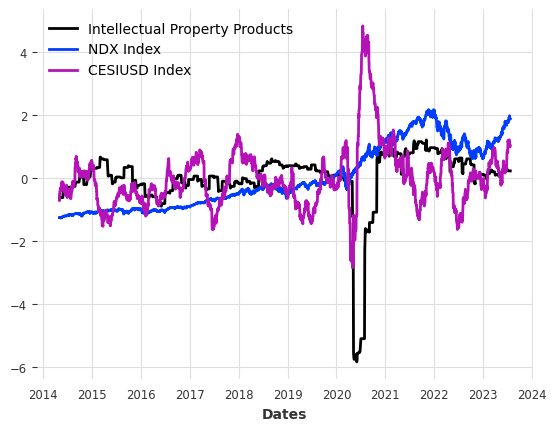

In [39]:
past_cov_train_scaled_ds.plot()

In [40]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=50,
    min_delta=0.005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "cpu"}

# To use GPU
# pl_trainer_kwargs={"callbacks": [my_stopper],
#                    "accelerator": "gpu",
#                    "devices": [0]}

In [41]:
# predict 15 days considering the latest 45 days
input_chunk_length=45
output_chunk_length=7


model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    dropout=0.5,
    torch_metrics=MeanAbsoluteError(),
    n_epochs=100,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
    n_rnn_layers=6,
    hidden_dim=50
)

In [42]:
model_pastcov.fit(
    series=y_train_scaled_ds,                     # the target training data
    past_covariates=past_cov_train_scaled_ds,     # the multi covariate features training data
    val_series=y_val_scaled_ds,                   # the target validation data
    val_past_covariates=past_cov_val_scaled_ds,   # the multi covariate features validation data
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=50, n_rnn_layers=6, hidden_fc_sizes=None, dropout=0.5, input_chunk_length=45, output_chunk_length=7, torch_metrics=MeanAbsoluteError(), n_epochs=100, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x2b1f3dbd0>], 'accelerator': 'cpu'}, random_state=0)

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Dates'>

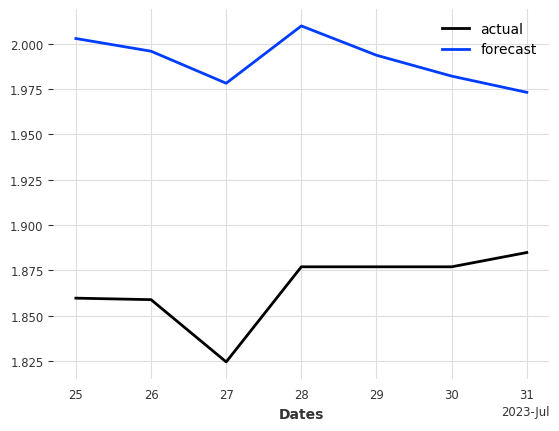

In [43]:
pred_cov = model_pastcov.predict(n=7,                        # n of days to predict
                                 series=y_train_scaled_ds[-45:],  # target input for prediction
                                 past_covariates=past_cov_train_scaled_ds[-45:]) # past-covariates input for prediction

y_val_scaled_ds[:7].plot(label="actual")
pred_cov.plot(label="forecast")

In [66]:
test = pd.read_csv('predict_set_w_btm.csv', index_col='Dates', parse_dates=True)

y_test = test[['SPX Index ']]
past_cov_test = test[['Intellectual Property Products', 'NDX Index ', 'CESIUSD Index']]


In [67]:
px.line(y_test)

In [68]:
px.line(past_cov_test)

In [69]:
y_test_dartseries = TimeSeries.from_dataframe(y_test, freq='D')
past_cov_test_dartseries = TimeSeries.from_dataframe(past_cov_test, freq='D')

<Axes: xlabel='Dates'>

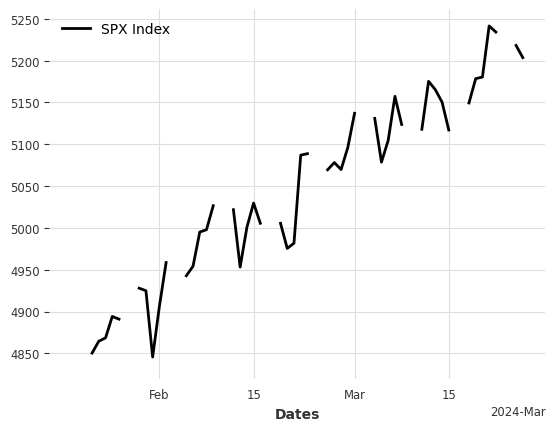

In [70]:
y_test_dartseries.plot()

<Axes: xlabel='Dates'>

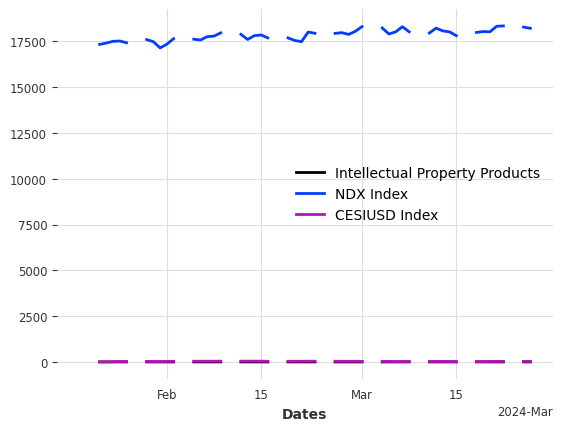

In [71]:
past_cov_test_dartseries.plot()

In [72]:
past_cov_test_dartseries.pd_dataframe().isna().sum().sort_values(ascending=False)

component
Intellectual Property Products    20
NDX Index                         20
CESIUSD Index                     20
dtype: int64

<Axes: xlabel='Dates'>

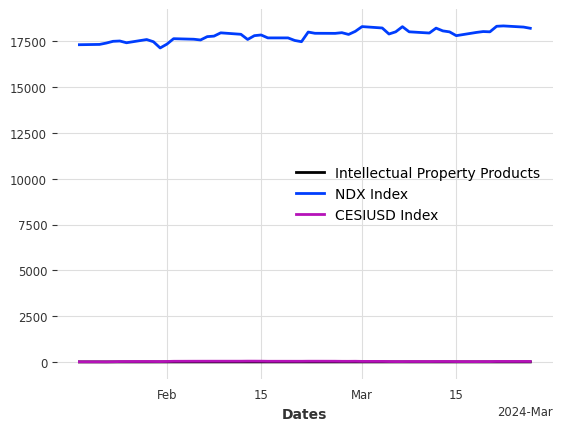

In [73]:
from darts.utils.missing_values import fill_missing_values
y_test_dartseries = fill_missing_values(y_test_dartseries)
past_cov_test_dartseries = fill_missing_values(past_cov_test_dartseries)
past_cov_test_dartseries.plot()

In [74]:
past_cov_test_dartseries.pd_dataframe().isna().sum().sort_values(ascending=False)

component
Intellectual Property Products    0
NDX Index                         0
CESIUSD Index                     0
dtype: int64

In [75]:
scaler = StandardScaler()
past_cov_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)

In [76]:
y_train_scaled_ds = target_transformer.fit(y_train_ds)
y_test_scaled_ds = target_transformer.transform(y_test_dartseries)
past_cov_train_scaled_ds = past_cov_transformer.fit_transform(past_cov_train_ds)
past_cov_test_scaled_ds = past_cov_transformer.transform(past_cov_test_dartseries)

<Axes: xlabel='Dates'>

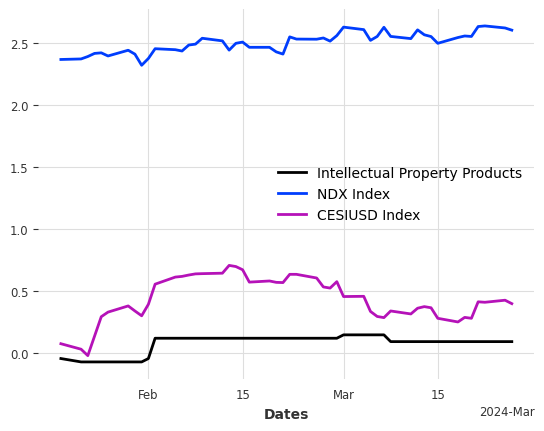

In [77]:
past_cov_test_scaled_ds.plot()

In [78]:
y_test_dartseries

<TimeSeries (DataArray) (Dates: 68, component: 1, sample: 1)> Size: 544B
array([[[4839.81      ]],

       [[4843.35      ]],

       [[4846.89      ]],

       [[4850.43      ]],

       [[4864.6       ]],

       [[4868.55      ]],

       [[4894.16      ]],

       [[4890.97      ]],

       [[4903.29      ]],

       [[4915.61      ]],

...

       [[5138.64333333]],

       [[5149.42      ]],

       [[5178.51      ]],

       [[5180.4       ]],

       [[5241.53      ]],

       [[5234.18      ]],

       [[5228.85      ]],

       [[5223.52      ]],

       [[5218.19      ]],

       [[5203.58      ]]])
Coordinates:
  * Dates      (Dates) datetime64[ns] 544B 2024-01-19 2024-01-20 ... 2024-03-26
  * component  (component) object 8B 'SPX Index '
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [92]:
y_test_scaled_ds.index = y_test.index
past_cov_test_scaled_ds.index=past_cov_test.index

In [93]:
y_test_scaled_ds.index

DatetimeIndex(['2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30',
               '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-05',
               '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09',
               '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15',
               '2024-02-16', '2024-02-19', '2024-02-20', '2024-02-21',
               '2024-02-22', '2024-02-23', '2024-02-26', '2024-02-27',
               '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-04',
               '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
               '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14',
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [ ]:
target_transformer.inverse_transform(temp).values()
print(target_transformer.inverse_transform(y_val_scaled_ds[Target][15]).values())

In [105]:
pred_cov

<TimeSeries (DataArray) (Dates: 7, component: 1, sample: 1)> Size: 56B
array([[[2.03818627]],

       [[2.03184298]],

       [[2.01742164]],

       [[2.03709161]],

       [[2.03142054]],

       [[2.02423729]],

       [[1.9943361 ]]])
Coordinates:
  * Dates      (Dates) datetime64[ns] 56B 2024-03-04 2024-03-05 ... 2024-03-10
  * component  (component) object 8B 'SPX Index '
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Predicting: |          | 0/? [00:00<?, ?it/s]

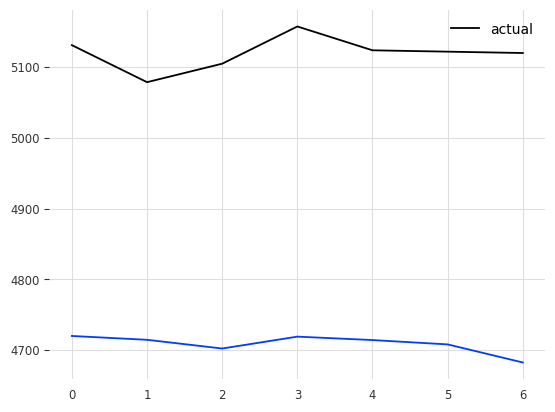

In [104]:
pred_cov = model_pastcov.predict(n=7,                        # n of days to predict
                                 series=y_test_scaled_ds[0:45],  # target input for prediction
                                 past_covariates=past_cov_test_scaled_ds[0:45]) # past-covariates input for prediction

#target_transformer.inverse_transform(temp).values()
plt.plot(target_transformer.inverse_transform(y_test_scaled_ds[45:52]).values(), label='actual')
plt.plot(target_transformer.inverse_transform(pred_cov).values())
plt.legend(loc="best")

In [91]:
pred_cov

<TimeSeries (DataArray) (Dates: 7, component: 1, sample: 1)> Size: 56B
array([[[2.03818679]],

       [[2.0318433 ]],

       [[2.01742947]],

       [[2.03709776]],

       [[2.03142721]],

       [[2.02424191]],

       [[1.9943408 ]]])
Coordinates:
  * Dates      (Dates) datetime64[ns] 56B 2024-03-27 2024-03-28 ... 2024-04-02
  * component  (component) object 8B 'SPX Index '
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None